In [40]:
import networkx as nx
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
import urllib.request
import pandas as pd
import zipfile
import folium
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [41]:
# EPRACCUR GP Practice data ingestion
#-----------------------------------------

url = 'https://files.digital.nhs.uk/assets/ods/current/epraccur.zip'
filehandle, _ = urllib.request.urlretrieve(url)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
first_file = zip_file_object.namelist()[0]
file = zip_file_object.open(first_file)
content = file.read()
csv_file = open('data/epraccur_data.csv', 'wb')
csv_file.write(content)
csv_file.close()
header_list = ["Organisation Code", "Name", "National Grouping", "High Level Health Geography", "Address line 1", "Address line 2", "Address line 3", 
"Address line 4", "Address line 5","Postcode","Open Date","Close Date","Status Code","Organisation Sub-Type Code","Commissioner","Join Provider/Purchaser Date",
"Left Provider/Purchaser Date","Contact Telephone Number", "Null 1", "Null 2", "Null 3", "Amended Record Indicator", "Null 4", "Provider/Purchaser",
"Null 5", "Prescribing Setting", "Null 6"]

# GP Practice Data Processing
#-----------------------------------------
gp_practice_df = pd.read_csv('data/epraccur_data.csv', names=header_list)
gp_practice_df = gp_practice_df[(gp_practice_df["Status Code"] == "A") & (gp_practice_df["Prescribing Setting"] == 4) #----------- Selecting only Active and Standard GP Practices form the data
& (gp_practice_df["Postcode"].str.contains('CB1 |CB2 |CB3 |CB4 |CB5 '))].reset_index(drop = True) #----------- Central cambridge defined as having the following postcodes: CB1, CB2, CB3, CB4, CB5
gp_practice_df['Full Address'] = gp_practice_df[['Address line 2', 'Address line 3', 'Address line 4',]].astype(str).agg(', '.join, axis=1)
gp_practice_df['Full Address'] = gp_practice_df['Full Address'].str.title() + ', ' + gp_practice_df['Postcode']
gp_practice_df['Full Address'] = gp_practice_df['Full Address'].str.replace('Nan', '').str.replace(' ,', ' ')
gp_practice_df['Name'] = gp_practice_df['Name'].str.title()
gp_practice_df_1 = gp_practice_df[['Organisation Code', 'Name', 'Full Address', 'Postcode', 'Contact Telephone Number']]

In [42]:

# Geolocation of GP practices in Cambridge
#-----------------------------------------
gp_practice_df_saved = pd.read_csv('data/cambridge_gp_practices.csv', index_col = 0)
new_list = list(gp_practice_df_1['Organisation Code'])
saved_list = list(gp_practice_df_saved['Organisation Code'])
new_orgs = list(set(new_list) - (set(saved_list)))
if new_orgs:
    geolocator = Nominatim(user_agent="open_access_nhs")
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
    gp_practice_df_1["location"] = gp_practice_df_1["Postcode"].apply(geolocator.geocode)
    gp_practice_df_1["Point"] = gp_practice_df_1["location"].apply(lambda loc: tuple(loc.point) if loc else None)
    gp_practice_df_1[['Latitude', 'Longitude', 'Altitude']] = gp_practice_df_1['Point'].to_list()
    gp_practice_df_2 = gp_practice_df_1[["Organisation Code","Name", "Full Address", "Postcode", "Contact Telephone Number", "Latitude", "Longitude"]]
    gp_practice_df_2.to_csv('data/cambridge_gp_practices.csv')
else:
    gp_practice_df_2 = gp_practice_df_saved.copy()
    print('No new cambridge GP practices')

No new cambridge GP practices


In [43]:
gp_practice_df_2

,Organisation Code,Name,Full Address,Postcode,Contact Telephone Number,Latitude,Longitude
0,D81001,Lensfield Medical Practice,"48 Lensfield Road, Cambridge, Cambridgeshire, ...",CB2 1EH,01223 651020,52.198432,0.124482
1,D81002,Huntingdon Road Surgery,"1 Huntingdon Road, Cambridge, CB3 0DB",CB3 0DB,01223 364127,52.214271,0.110002
2,D81003,York Street Medical Practice,"146-148 York Street, Cambridge, Cambridgeshire...",CB1 2PY,01223 364116,52.205423,0.141534
3,D81005,Newnham Walk Surgery,"Wordsworth Grove, Cambridge, Cambridgeshire, C...",CB3 9HS,01223 366811,52.199355,0.110527
4,D81012,Cornford House Surgery,"364 Cherry Hinton Road, Cambridge, Cambridgesh...",CB1 8BA,01223 247505,52.185938,0.157111
5,D81013,Trumpington Street Medical Practice,"56 Trumpington Street, Cambridge, Cambridgeshi...",CB2 1RG,01223 361611,52.202462,0.117942
6,D81016,Arbury Road Surgery,"114 Arbury Road, Cambridge, Cambridgeshire, CB...",CB4 2JG,01223 364433,52.225822,0.128139
7,D81017,Mill Road Surgery,"Cambridge, Cambridgeshire, CB1 3DG",CB1 3DG,01223 247812,52.197156,0.150585
8,D81025,Cherry Hinton Medical Centre,"34 Fishers Lane, Cherry Hinton, Cambridge, CB1...",CB1 9HR,01223 652221,52.187598,0.177692
9,D81037,Bridge Street Medical Centre,"Passage,Off Bridge St, Cambridge, CB2 3LS",CB2 3LS,01223 652671,52.207742,0.118854


In [44]:
# Map visulation of Cambridge GP practices
#-----------------------------------------
frame = folium.Figure(width=500, height=500)
folium_fig = folium.Map(
    location=[52.2, 0.12],
    tiles="cartodbpositron",
    zoom_start=12).add_to(frame)
for code, name, address, number, lat, lon in zip(gp_practice_df_2['Organisation Code'],
gp_practice_df_2['Name'],
gp_practice_df_2['Full Address'],
gp_practice_df_2['Contact Telephone Number'],
gp_practice_df_2['Latitude'],
gp_practice_df_2['Longitude']):
    folium.Marker(
        [lat, lon],
        popup = folium.Popup('<b>' + 'Name: ' + '</b>'  + str(name) + '<br>'
        '<b>' + 'GP Practice Code: ' + '</b>' + str(code) + '<br>'
        '<b>' + 'Address: ' + '</b>' + str(address) + '<br>'
        '<b>' + 'Telephone Number: ' + '</b>' + str(number) + '<br>',
        max_width=len(address)*20),
        icon=folium.Icon(color="darkblue", prefix='fa', icon="fa-medkit"),
        ).add_to(folium_fig)
folium_fig 

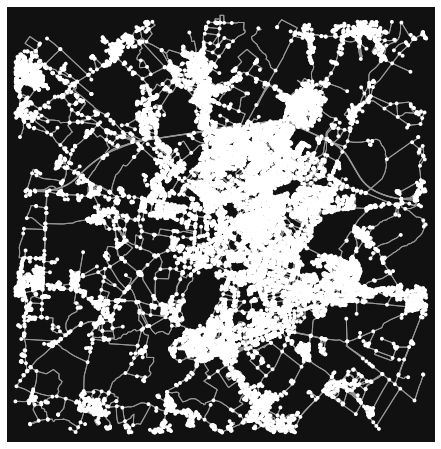

In [45]:
#Time of travel (walking) analysis for GP practices in central Cambridge (7000 meters from centre)
place = "Cambridge, England"
mode = "walk"
G = ox.graph_from_address(place, dist = 7000, simplify=True, network_type=mode)
fig, ax = ox.plot_graph(G);

In [46]:
#gp_practice_df_2 = gp_practice_df_2.head(n=3)
# gp_practice_df_2

In [47]:

point_of_interest = ox.distance.nearest_nodes(G, X = gp_practice_df_2['Longitude'], Y=gp_practice_df_2['Latitude']) # X = longitude, Y = Latitude


In [61]:
# Trip time in Mintues
trip_times = [5,10,20]

# walking speed in km/hour
travel_speed = 4.5

# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute


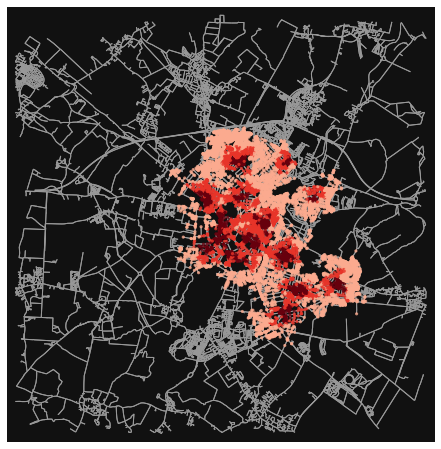

In [62]:
# 1 - get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)
# 2 - color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    for points in point_of_interest:
        subgraph = nx.ego_graph(G, points, radius=trip_time, distance='time')
        for node in subgraph.nodes():
            node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [10 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)

In [63]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    isochrone_polys_sub = []
    for points in point_of_interest:
        subgraph = nx.ego_graph(G, points, radius=trip_time, distance='time')
        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
        isochrone_polys_sub.append(bounding_poly)
    isochrone_polys.append(isochrone_polys_sub)

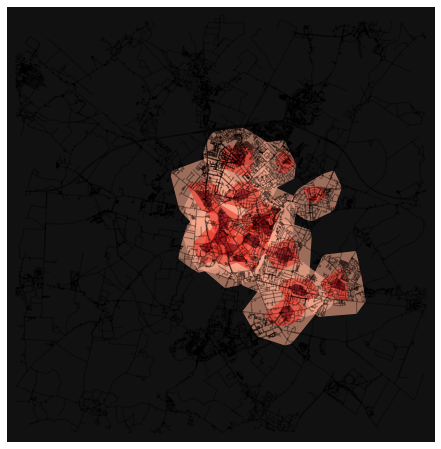

In [64]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    for subpolygon in polygon:
        patch = PolygonPatch(subpolygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
        ax.add_patch(patch)
plt.show()

In [52]:
gdf_index = list(gp_practice_df_2['Organisation Code'])
for polygon in isochrone_polys:
    gdf = gpd.GeoDataFrame({"GP Practice": gdf_index}, geometry= polygon)
gdf

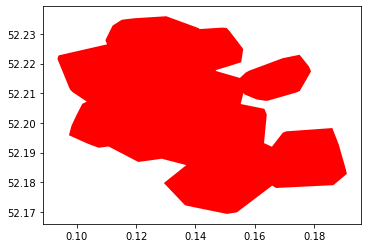

In [54]:
from shapely.ops import cascaded_union
polygons = list(gdf['geometry'])
boundary = gpd.GeoSeries(cascaded_union(polygons))
boundary.plot(color = 'red')
plt.show()

In [59]:
geo_json = gpd.GeoSeries(cascaded_union(polygons)).to_json()

In [60]:
folium.GeoJson(
    geo_json,
    name="10 min walking limit",
    style_function=lambda feature: {
        "fillColor": 'Blue',
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.1,
    },
).add_to(folium_fig)
folium_fig 